In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

X_data = (train_data.drop(train_data.columns[0], axis=1).values).astype('float32')
#X = train_data.values
y_data = train_data['label'].values

X_test = (test_data.values).astype('float32')

#to transform
train_mean = X_data.mean()/255
train_std = X_data.std()/255

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=1)


X_train = X_train.reshape(-1, 28, 28)
X_val = X_val.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(X_test.shape)

(33600, 28, 28)
(33600,)
(8400, 28, 28)
(28000, 28, 28)


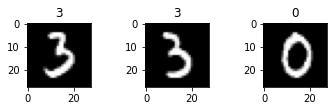

In [4]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

In [5]:
class MNISTDataset(Dataset):
    def __init__(self, X, y, transform=None):
        
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        
        return len(self.X)

    def __getitem__(self, n):
        
        image = self.X[n].reshape((28,28)).astype(np.uint8)
        label = self.y[n]
        
        if self.transform:
            
            image = self.transform(image)
        
        return (image, label)

In [6]:
# Initialize transformation, datasets, and loaders
batch_size = 32
classes = range(10)
train_transform = transforms.Compose(
                    [
                    transforms.ToPILImage(),
#                     transforms.RandomRotation(30),
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[train_mean], std=[train_std]),
                    ])
# don't (really) need the data augmentation in validation
val_transform = transforms.Compose(
                    [
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[train_mean], std=[train_std]),
                    ])

test_transform = val_transform

train_dataset = MNISTDataset(X_train, y_train, transform = train_transform)
train_loader = DataLoader(dataset=train_dataset,
                                batch_size=batch_size,shuffle = True)
val_dataset = MNISTDataset(X_val, y_val, transform = val_transform)
val_loader = DataLoader(dataset=val_dataset,
                                batch_size=batch_size,shuffle = False)

5


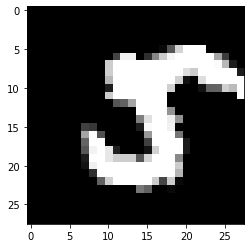

In [11]:
imgs, lbls = next(iter(train_loader))
print(classes[lbls[0]])
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

In [70]:
class SqueezeExiteBlock(nn.Module):
    def __init__(self, filters: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(filters, filters//32)
        self.fc2 = nn.Linear(filters//32, filters)
        self.dropout = nn.Dropout()

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x_squeezed = F.adaptive_avg_pool2d(x, 1)

        x_squeezed = x_squeezed.view((-1, 128))
        x_squeezed = F.relu(self.fc1(self.dropout(x_squeezed)), inplace=True)

        x_squeezed = torch.sigmoid(self.fc2(self.dropout(x_squeezed))).view((-1, 128, 1, 1))

        x_squeezed = x.mul(x_squeezed)

        return x_squeezed


class BasicConvBlock(nn.Module):
    def __init__(self, h: int, w: int, inp: int , filters: int = 128) -> None:
        super().__init__()
        self.h, self.w = h, w
        self.inp = inp

        self.conv = nn.Sequential(
            nn.Conv2d(inp, filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.bn = nn.BatchNorm2d(128)
        self.se = SqueezeExiteBlock(128) 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = x.view((-1, self.inp, self.w, self.h))

        x = self.conv(x)

        x = self.bn(x)
        x = self.se(x)

        return x


class MNIST(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.block1 = BasicConvBlock(28,28,1)
        self.block2 = BasicConvBlock(28,28,128)
        self.block3 = BasicConvBlock(14,14,128)

        self.avg = nn.AvgPool2d(kernel_size=2)
        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        self.global_max = nn.AdaptiveMaxPool2d((1,1))

        self.fc = nn.Linear(128, 10, bias=False)
        self.dropout = nn.Dropout()

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.block1(x)
        x = self.block2(x)
        x = self.avg(x)

        x = self.block3(x)
        
        x1 = self.global_avg(x).view((-1,128))
        x2 = self.global_max(x).view((-1,128))
        x0 = self.fc(self.dropout(x1)) + self.fc(self.dropout(x2))
        
        return x0 


In [71]:
#check how many preds match labels

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [73]:
#TRAIN

model = MNIST()
model.to(device)

lr = 0.001
epochs = 20

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[13,16,19], gamma=0.1)

for epoch in range(epochs):

    epoch_loss = 0
    epoch_correct = 0

    model.train()

    for images, labels in train_loader:

        preds = model(images)
        optimizer.zero_grad()
        
        loss = loss_function(preds, labels)

        loss.backward() 
        optimizer.step()

        epoch_loss += loss.item() * batch_size
        epoch_correct += get_num_correct(preds, labels)

    exp_lr_scheduler.step()
    model.eval()

    val_loss = 0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
           
            preds = model(images) 
            loss = loss_function(preds, labels) 
            
            val_correct += get_num_correct(preds, labels)
            val_loss = loss.item() * batch_size

    print(" Val Loss: ", val_loss)
    print(" Val Acc: ", (val_correct/len(X_val))*100)

KeyboardInterrupt: 